In [1]:
import tensorflow as tf
from tf_agents.utils import common
from tf_agents.specs import tensor_spec
import numpy as np
from tf_agents.replay_buffers import reverb_replay_buffer
from tf_agents.replay_buffers import reverb_utils
from tf_agents.metrics import tf_metrics
from tf_agents.specs import BoundedArraySpec, ArraySpec
from tf_agents.environments import py_environment, tf_py_environment
from tf_agents.trajectories import time_step as ts
from tf_agents.environments import suite_gym
import tf_agents
from tf_agents import drivers
from tf_agents.environments import wrappers
from tf_agents.networks.q_network import QNetwork
from tf_agents.environments import utils
from tf_agents.agents.dqn import dqn_agent
from tf_agents.replay_buffers import tf_uniform_replay_buffer

In [27]:
class Env(py_environment.PyEnvironment):

    def __init__(self) -> None:
        self._action_spec = BoundedArraySpec(shape=(1,), minimum=0, maximum=10_000, dtype=np.float64, name="action")
        self._observation_spec = ArraySpec(shape=(1,), dtype=np.float64, name="state")
        # self._reward_spec = BoundedArraySpec(shape=(1,), dtype=np.float64, minimum=-np.inf, maximum=0, name="reward")
        # self._discount_spec = BoundedArraySpec(shape=(1,), dtype=np.float32, name="discount")
        self._state = np.array([0], dtype=np.float64)
        self._episode_ended = False
        
        self._current_time_step = 0
        self._steps_done = 0

        self.storage_cost = 3
        self.backlog_cost = 2


    def action_spec(self):
        return self._action_spec

    def observation_spec(self):
        return self._observation_spec

    def _reset(self):
        self._state = np.array([0], dtype=np.float64)
        self._episode_ended = False
        self._current_time_step = 0
        self._steps_done = 0
        return ts.restart(np.array(self._state, dtype=np.float64))

    def _step(self, action):

        if self._episode_ended:
            return self.reset()

        self._steps_done += 1

        if self._steps_done  == 100:
            self._episode_ended = True



        # action is an array.
        new_state = self._state[0] - np.random.normal(2000) + action[0]



        reward = (self._state - np.abs(new_state))[0]
        
        
        # reward = 1/(np.abs(new_state)+0.00001)
        
        
        # reward = - np.abs(new_state)
        # print(reward, reward_)


        self._state = np.array([new_state], dtype=np.float64)

        # if new_state > 0:
        #     reward = - new_state * self.storage_cost
        # else:
        #     reward = new_state * self.backlog_cost
        

        if self._episode_ended:
            return ts.termination(self._state, reward=reward)
        else:
            return ts.transition(self._state, reward=reward, discount=0.9)

In [28]:
env = Env()
discretized_env = wrappers.ActionDiscretizeWrapper(env, num_actions=11)
tf_env = tf_py_environment.TFPyEnvironment(discretized_env)

In [29]:
q_net = QNetwork(
    tf_env.observation_spec(),
    tf_env.action_spec(),
    batch_squash=True
    # preprocessing_layers=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=0)),
)

In [30]:
fc_layer_params = (100, 50)
action_tensor_spec = tensor_spec.from_spec(tf_env.action_spec())
num_actions = action_tensor_spec.maximum - action_tensor_spec.minimum + 1

# Define a helper function to create Dense layers configured with the right
# activation and kernel initializer.
def dense_layer(num_units):
  return tf.keras.layers.Dense(
      num_units,
      activation=tf.keras.activations.relu,
      kernel_initializer=tf.keras.initializers.VarianceScaling(
          scale=2.0, mode='fan_in', distribution='truncated_normal'))

# QNetwork consists of a sequence of Dense layers followed by a dense layer
# with `num_actions` units to generate one q_value per available action as
# its output.
dense_layers = [dense_layer(num_units) for num_units in fc_layer_params]
q_values_layer = tf.keras.layers.Dense(
    num_actions,
    activation=None,
    kernel_initializer=tf.keras.initializers.RandomUniform(
        minval=-0.03, maxval=0.03),
    bias_initializer=tf.keras.initializers.Constant(-0.2))
q_net = tf_agents.networks.Sequential(dense_layers + [q_values_layer])

In [31]:
# the q_net receives a STATE and returns Q Values
# q_net = QNetwork(
#     tf_env.observation_spec(),
#     tf_env.action_spec(),
#     batch_squash=True
#     # preprocessing_layers=tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=0)),
# )


optimizer = tf.keras.optimizers.Adam(learning_rate=0.01)
train_step_counter = tf.Variable(0)

agent = dqn_agent.DqnAgent(
    tf_env.time_step_spec(),
    tf_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=train_step_counter
)

agent.initialize()

# a policy receives a TIMESTEP and returns an ACTION
collect_policy = agent.collect_policy
policy = agent.collect_policy

In [32]:
# table_name = 'uniform_table'
# replay_buffer_signature = tensor_spec.from_spec(
#       agent.collect_data_spec)
# replay_buffer_signature = tensor_spec.add_outer_dim(
#     replay_buffer_signature)
# 
# replay_buffer_max_length = 1_000
# 
# table = reverb.Table(
#     table_name,
#     max_size=replay_buffer_max_length,
#     sampler=reverb.selectors.Uniform(),
#     remover=reverb.selectors.Fifo(),
#     rate_limiter=reverb.rate_limiters.MinSize(1),
#     signature=replay_buffer_signature)
# 
# reverb_server = reverb.Server([table])
# 
# replay_buffer = reverb_replay_buffer.ReverbReplayBuffer(
#     agent.collect_data_spec,
#     table_name=table_name,
#     sequence_length=2,
#     local_server=reverb_server)
# 
# rb_observer = reverb_utils.ReverbAddTrajectoryObserver(
#   replay_buffer.py_client,
#   table_name,
#   sequence_length=2)

In [33]:
replay_buffer_capacity = 1000

replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    agent.collect_data_spec,
    batch_size=tf_env.batch_size,
    max_length=replay_buffer_capacity)

In [34]:
avg_return = tf_metrics.AverageReturnMetric()
avg_episode_length = tf_metrics.AverageEpisodeLengthMetric()

In [35]:
observers = [replay_buffer.add_batch, avg_return, avg_episode_length]

In [36]:
#  should only be used for episodic environments
tf_driver = drivers.dynamic_step_driver.DynamicStepDriver(
    env=tf_env,
    policy=agent.collect_policy,
    observers=observers,
    num_steps=20
)

In [37]:
tf_driver.run()

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.9], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2994.56436945]])>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.71627915], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([1])>}),
 ())

In [38]:
batch_size = 32

dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

In [39]:
iterator = iter(dataset)
# print(iterator)

In [40]:
returns1 = []

In [ ]:
for _ in range(500):
    time_step, _ = tf_driver.run()
    
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    returns1.append(avg_return.result().numpy())
    
    if len(returns1) % 20 == 0:
        print(np.mean(returns1[-100:]))

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px

px.line(np.array(returns))

In [44]:
px.line(np.array(returns1))

In [ ]:
px.line(np.array(returns))

In [ ]:
returns

In [ ]:
time_step = tf_env.reset()
iterator = iter(replay_buffer.as_dataset())
agent.train_step_counter.assign(0)

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=0>

In [34]:
iterator = iter(replay_buffer.as_dataset(num_steps=2))

In [35]:
next(iterator)

(Trajectory(
 {'action': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([7, 7], dtype=int32)>,
  'discount': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([1., 0.], dtype=float32)>,
  'next_step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 2], dtype=int32)>,
  'observation': <tf.Tensor: shape=(2, 1), dtype=float64, numpy=
 array([[30666.66666667],
        [36444.44444444]])>,
  'policy_info': (),
  'reward': <tf.Tensor: shape=(2,), dtype=float32, numpy=array([-36444.445, -42222.223], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(2,), dtype=int32, numpy=array([1, 1], dtype=int32)>}),
 BufferInfo(ids=<tf.Tensor: shape=(2,), dtype=int64, numpy=array([19, 20])>, probabilities=<tf.Tensor: shape=(), dtype=float32, numpy=0.03125>))

In [ ]:
train_loss = agent.train(experience)

In [ ]:
experience, _ = next(iterator)

In [ ]:
returns = []

In [ ]:
tf_driver.run()

(TimeStep(
 {'discount': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>,
  'observation': <tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[5000.]])>,
  'reward': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.], dtype=float32)>,
  'step_type': <tf.Tensor: shape=(1,), dtype=int32, numpy=array([0])>}),
 ())

In [ ]:
next(iterator)

In [ ]:
for _ in range(100):
    tf_driver.run()
    dataset = replay_buffer.as_dataset(
    num_parallel_calls=3,
    sample_batch_size=8,
    num_steps=2).prefetch(3)

    iterator = iter(dataset)
    
    experience, _ = next(iterator)
    train_loss = agent.train(experience).loss
    step = agent.train_step_counter.numpy()
    print(returns.append(avg_return.result().numpy()))

In [ ]:
import matplotlib.pyplot as plt

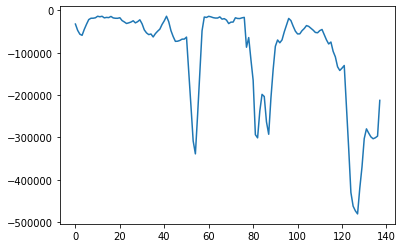

In [ ]:
plt.plot(returns)